In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/Reddit_Encoded(No Stop Words).csv'
df = pd.read_csv(file_path)
print(df.head())

                                             comment  hate_speech  \
0  subsection retarded hungarians ohh boy brace l...            1   
1  hiii just got work foundation grounding mainly...            0   
2                    wow guess soyboys every country            0   
3  owen benjamins soyboy song goes every country ...            0   
4  yall hear sumn means live small town right now...            0   

                                  lemmatized_comment  \
0  subsection retard hungarians ohh boy brace liv...   
1  hiii just get work foundation ground mainly ty...   
2                    wow guess soyboys every country   
3  owen benjamins soyboy song go every country th...   
4  yall hear sumn mean live small town right now ...   

                                document_vector_flat  
0  0.014043219,-0.01809359,0.017145459,0.08062436...  
1  -0.0031560725,-0.033554427,0.019422462,0.07846...  
2  0.017362628,0.005587179,0.0297773,0.109146975,...  
3  0.0122448,0.00724816,-5.1

In [4]:
# Convert the document vectors from their string representation back into numerical form
df['document_vector'] = df['document_vector_flat'].apply(lambda x: np.fromstring(x, sep=','))
print(df['document_vector'].head())

0    [0.014043219, -0.01809359, 0.017145459, 0.0806...
1    [-0.0031560725, -0.033554427, 0.019422462, 0.0...
2    [0.017362628, 0.005587179, 0.0297773, 0.109146...
3    [0.0122448, 0.00724816, -5.1360163e-05, 0.0789...
4    [0.015154357, 0.010861638, 0.018671766, 0.0720...
Name: document_vector, dtype: object


In [5]:
# Extract features (document vectors) and labels (binary hate speech)
X = np.array(df['document_vector'].tolist())
y = df['hate_speech']

# Check the shape of the dataset
print(X.shape)  # Expected shape: (num_samples, embedding_dim)
print(y.shape)  # Expected shape: (num_samples,)

(22178, 300)
(22178,)


## Split the data into train and test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Balance the data

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Shape data to match LSTM Input Shape

In [8]:
X_train_resampled = np.array(X_train_resampled)

# Check the shape of the resampled dataset
print(X_train_resampled.shape)  # Expected shape: (num_samples, embedding_dim)
print(y_train_resampled.shape)  # Expected shape: (num_samples,)

(27022, 300)
(27022,)


In [9]:
# Check dimensions
embedding_dim = X_train_resampled.shape[1]  # Number of features per document vector

# Reshape train data to match LSTM input (num_samples, sequence_length, embedding_dim)
# Here, sequence_length should be 1 since each comment is a single vector
X_train_resampled = np.expand_dims(X_train_resampled, axis=1)

print(X_train_resampled.shape)  # Should be (num_samples, 1, embedding_dim)

(27022, 1, 300)


In [10]:
# Reshape test data to match LSTM input (num_samples, sequence_length, embedding_dim)
# Here, sequence_length should be 1 since each comment is a single vector
X_test = np.expand_dims(X_test, axis=1)  # New shape: (num_samples, 1, embedding_dim)

print(X_test.shape)  # Should be (num_samples, 1, embedding_dim)

(4436, 1, 300)


## Single LSTM Layer

In [11]:
# Define the LSTM model
model1 = Sequential()

#Define LSTM layer
model1.add(LSTM(128, input_shape=(1, embedding_dim), return_sequences=True))

#Add Dropout Layer to prevent overfitting
model1.add(Dropout(0.2))

#Add another LSTM Layer
model1.add(LSTM(64))

#Add another Dropout Layer
model1.add(Dropout(0.2))

# Add the output layer with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            219648    
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 269121 (1.03 MB)
Trainable params: 269121 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Fit the model using the resampled data
model1.fit(X_train_resampled, y_train_resampled,
          epochs=50,
          batch_size=64,
          validation_split=0.2)

Epoch 1/50
338/338 [==============================] - 10s 8ms/step - loss: 0.5406 - accuracy: 0.7210 - val_loss: 0.6414 - val_accuracy: 0.5932
Epoch 2/50
338/338 [==============================] - 2s 6ms/step - loss: 0.4661 - accuracy: 0.7759 - val_loss: 0.6742 - val_accuracy: 0.5907
Epoch 3/50
338/338 [==============================] - 2s 6ms/step - loss: 0.4479 - accuracy: 0.7852 - val_loss: 0.6643 - val_accuracy: 0.6218
Epoch 4/50
338/338 [==============================] - 3s 8ms/step - loss: 0.4375 - accuracy: 0.7895 - val_loss: 0.5949 - val_accuracy: 0.6638
Epoch 5/50
338/338 [==============================] - 3s 8ms/step - loss: 0.4263 - accuracy: 0.7982 - val_loss: 0.6801 - val_accuracy: 0.6070
Epoch 6/50
338/338 [==============================] - 3s 8ms/step - loss: 0.4164 - accuracy: 0.8021 - val_loss: 0.5322 - val_accuracy: 0.7101
Epoch 7/50
338/338 [==============================] - 2s 6ms/step - loss: 0.4080 - accuracy: 0.8095 - val_loss: 0.5455 - val_accuracy: 0.6992
Epoch

In [13]:
# Predict on the test set
y_pred = (model1.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 1s 2ms/step


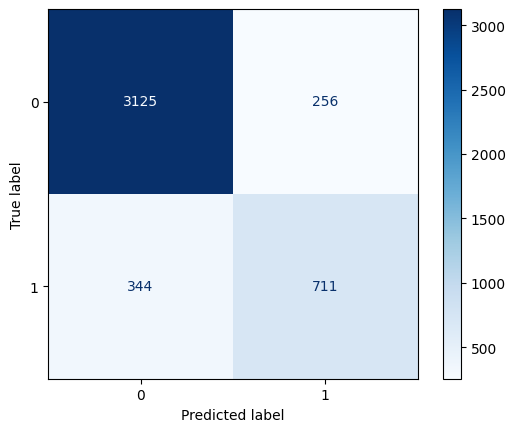

In [14]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8647
Precision: 0.7353
Recall: 0.6739
F1 Score: 0.7033


## Two Bidirectinal LSTM Layers

In [28]:
# Define the model
model3 = Sequential()

# Add Bidirectional LSTM layer
model3.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, embedding_dim)))

# Add Dropout Layer
model3.add(Dropout(0.2))

# Add another Bidirectional LSTM Layer
model3.add(Bidirectional(LSTM(64)))

# Add another Dropout Layer
model3.add(Dropout(0.2))

# Add the output layer with sigmoid activation for binary classification
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 1, 256)            439296    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 603777 (2.30 MB)
Trainable params: 60377

In [29]:
# Fit the model using the resampled data
model3.fit(X_train_resampled, y_train_resampled,
          epochs=50,
          batch_size=64,
          validation_split=0.2)

Epoch 1/50
338/338 [==============================] - 11s 14ms/step - loss: 0.5262 - accuracy: 0.7322 - val_loss: 0.7084 - val_accuracy: 0.5613
Epoch 2/50
338/338 [==============================] - 4s 11ms/step - loss: 0.4593 - accuracy: 0.7780 - val_loss: 0.5362 - val_accuracy: 0.7018
Epoch 3/50
338/338 [==============================] - 3s 8ms/step - loss: 0.4396 - accuracy: 0.7889 - val_loss: 0.5792 - val_accuracy: 0.6779
Epoch 4/50
338/338 [==============================] - 3s 8ms/step - loss: 0.4284 - accuracy: 0.7981 - val_loss: 0.5294 - val_accuracy: 0.7132
Epoch 5/50
338/338 [==============================] - 3s 10ms/step - loss: 0.4160 - accuracy: 0.8048 - val_loss: 0.4407 - val_accuracy: 0.7861
Epoch 6/50
338/338 [==============================] - 4s 11ms/step - loss: 0.4067 - accuracy: 0.8097 - val_loss: 0.5775 - val_accuracy: 0.6912
Epoch 7/50
338/338 [==============================] - 3s 9ms/step - loss: 0.3953 - accuracy: 0.8191 - val_loss: 0.4747 - val_accuracy: 0.7624
E

In [30]:
# Predict on the test set
y_pred = (model3.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 2s 3ms/step


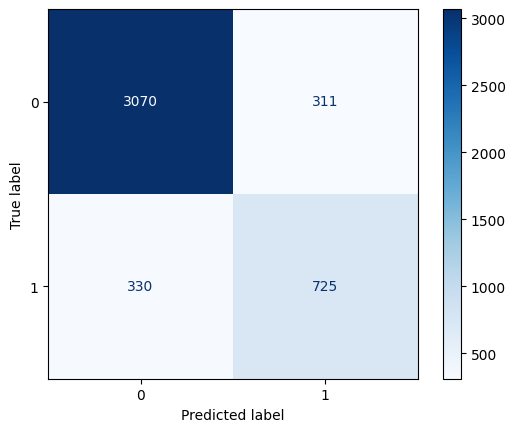

In [31]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8555
Precision: 0.6998
Recall: 0.6872
F1 Score: 0.6934


## Two Bidirectinal LSTM Layers and One Dense Layer

In [33]:
# Define the model
model4 = Sequential()

# Add Bidirectional LSTM layer
model4.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, embedding_dim)))

# Add Dropout Layer
model4.add(Dropout(0.2))

# Add another Bidirectional LSTM Layer
model4.add(Bidirectional(LSTM(64)))

# Add another Dropout Layer
model4.add(Dropout(0.2))

# Add a Dense layer with ReLU activation
model4.add(Dense(128, activation='relu'))

# Add another Dropout Layer
model4.add(Dropout(0.2))

# Add the output layer with sigmoid activation for binary classification
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 1, 256)            439296    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)              

In [34]:
# Fit the model using the resampled data
model4.fit(X_train_resampled, y_train_resampled,
          epochs=50,
          batch_size=64,
          validation_split=0.2)

Epoch 1/50
338/338 [==============================] - 12s 14ms/step - loss: 0.5156 - accuracy: 0.7400 - val_loss: 0.6278 - val_accuracy: 0.6944
Epoch 2/50
338/338 [==============================] - 3s 9ms/step - loss: 0.4568 - accuracy: 0.7792 - val_loss: 0.7233 - val_accuracy: 0.6357
Epoch 3/50
338/338 [==============================] - 4s 11ms/step - loss: 0.4429 - accuracy: 0.7903 - val_loss: 0.8729 - val_accuracy: 0.4918
Epoch 4/50
338/338 [==============================] - 4s 11ms/step - loss: 0.4239 - accuracy: 0.8009 - val_loss: 0.6451 - val_accuracy: 0.6653
Epoch 5/50
338/338 [==============================] - 3s 9ms/step - loss: 0.4083 - accuracy: 0.8118 - val_loss: 0.6638 - val_accuracy: 0.6026
Epoch 6/50
338/338 [==============================] - 3s 9ms/step - loss: 0.3982 - accuracy: 0.8215 - val_loss: 0.3784 - val_accuracy: 0.8649
Epoch 7/50
338/338 [==============================] - 3s 9ms/step - loss: 0.3867 - accuracy: 0.8292 - val_loss: 0.3646 - val_accuracy: 0.8618
Ep

In [35]:
# Predict on the test set
y_pred = (model4.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 2s 4ms/step


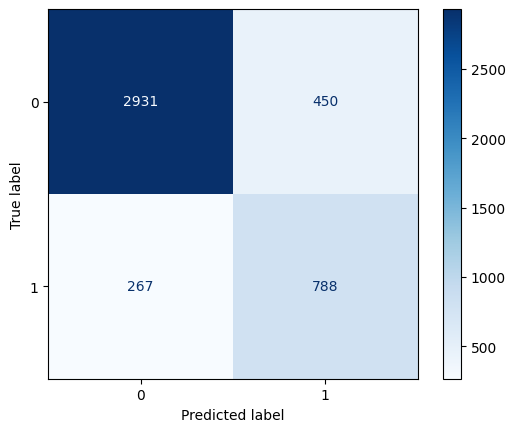

In [36]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [37]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8384
Precision: 0.6365
Recall: 0.7469
F1 Score: 0.6873


### Adding dense layer is decreasing the performance of the model. So it's better to not add dense layer to the model. And normal LSTM is giving better results than Bidirectional LSTM

# Model Tuning

## Implement early stopping and learning rate reduction techniques, while ensuring that 'y_pred' achieves a balanced precision and recall.

In [44]:
# Define the LSTM model
model = Sequential()

#Define LSTM layer
model.add(LSTM(128, input_shape=(1, embedding_dim), return_sequences=True))

#Add Dropout Layer to prevent overfitting
model.add(Dropout(0.2))

#Add another LSTM Layer
model.add(LSTM(64))

#Add another Dropout Layer
model.add(Dropout(0.2))

# Add the output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 128)            219648    
                                                                 
 dropout_10 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 269121 (1.03 MB)
Trainable params: 269121 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Early stopping is a technique used to prevent overfitting of a model to the training data. It works by monitoring the performance of the model on a separate validation dataset during training. If the performance (e.g., validation loss or accuracy) stops improving or starts deteriorating for a certain number of epochs, training is halted early. This prevents the model from continuing to learn patterns specific to the training data that do not generalize well to unseen data.

### Learning rate reduction is a technique to improve the convergence of the model during training. It involves reducing the learning rate when the validation performance plateaus. This helps the model to fine-tune more precisely towards the optimal parameters.

In [45]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

In [50]:
# Fit the model with early stopping and learning rate reduction
history = model.fit(X_train_resampled, y_train_resampled,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
338/338 [==============================] - 3s 8ms/step - loss: 0.3494 - accuracy: 0.8440 - val_loss: 0.4260 - val_accuracy: 0.7950 - lr: 1.0000e-04
Epoch 2/50
338/338 [==============================] - 3s 8ms/step - loss: 0.3479 - accuracy: 0.8450 - val_loss: 0.4530 - val_accuracy: 0.7769 - lr: 1.0000e-04
Epoch 3/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3472 - accuracy: 0.8458 - val_loss: 0.4398 - val_accuracy: 0.7876 - lr: 1.0000e-04
Epoch 4/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3457 - accuracy: 0.8467 - val_loss: 0.4444 - val_accuracy: 0.7852 - lr: 1.0000e-04
Epoch 5/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3447 - accuracy: 0.8479 - val_loss: 0.4406 - val_accuracy: 0.7883 - lr: 1.0000e-05
Epoch 6/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3456 - accuracy: 0.8463 - val_loss: 0.4481 - val_accuracy: 0.7809 - lr: 1.0000e-05


## Choose a threshold that balances precision and recall.

In [51]:
y_pred_prob = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Threshold
best_threshold = thresholds[np.argmax(precision * recall)]
y_pred = (y_pred_prob >= best_threshold).astype(int)

print("Best Threshold:", best_threshold)

139/139 [==============================] - 0s 2ms/step
Best Threshold: 0.556429


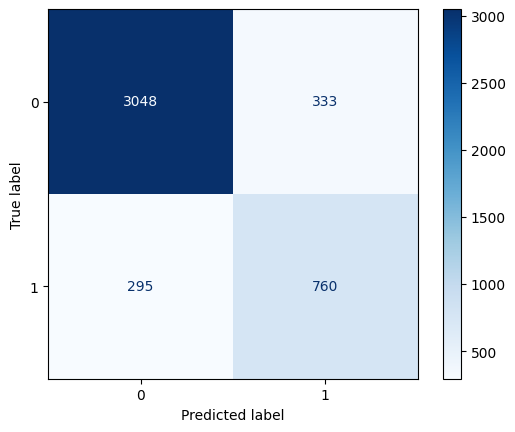

In [52]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [53]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8584
Precision: 0.6953
Recall: 0.7204
F1 Score: 0.7076
